# How to create tensorflow models

## Loading libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential, optimizers, Model, utils
from tensorflow.keras.applications import resnet50 # Name of the model you want to import
import tensorflow_hub as hub

## Sequential Models

In [2]:
seq_model = Sequential([
    layers.Conv2D(32, (3,3), input_shape=(224,224,3), activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, (5,5), activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, (7,7), activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(5),
    layers.Dense(1)
])

seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 64)        200768    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0

## Pretrained Model

### As it is

In [3]:
# resnet50.ResNet50?

In [4]:
model = resnet50.ResNet50() # The input shape can be seen in the above sell execution
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Only the models architecture

In [5]:
model = resnet50.ResNet50(weights=None)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### For Feature Extraction

In [6]:
model = resnet50.ResNet50()

# Making the layers non trainable
for layer in model.layers:
    layer.trainable = False
    
# Extracting the outputs till the desired layer
temp =  model.layers[-3].output

# Adding the new layesr

new_layer = Sequential([
    layers.Flatten(),
    layers.Dense(10),
    layers.Dropout(0.5),
    layers.Dense(1)
])

output = new_layer(temp)


final_model = Model(model.inputs, output)

In [7]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
final_model.layers[-1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1003530   
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,003,541
Trainable params: 1,003,541
Non-trainable params: 0
_________________________________________________________________


## Functional API

In [9]:
inputs = layers.Input(shape=(10,))
layer1 = layers.Dense(10, activation='relu')(inputs)

branch1 = layers.Dense(20, activation='relu')(layer1)
branch1 = layers.Dropout(0.5)(branch1)
branch1 = layers.Dense(30)(branch1)

branch2 = layers.Dense(15)(layer1)
branch2 = layers.Dense(30)(branch2)

concat = layers.Concatenate()([branch1, branch2])

output = layers.Dense(1)(concat)

final_model = Model(inputs, output)

In [10]:
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 10)           110         input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 20)           220         dense_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 20)           0           dense_5[0][0]                    
____________________________________________________________________________________________

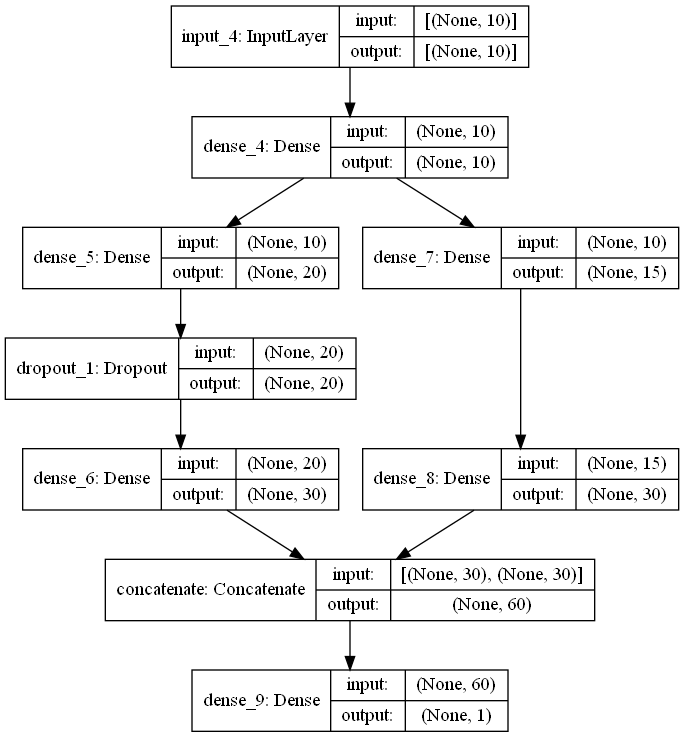

In [11]:
utils.plot_model(final_model, show_shapes=True) # This will also save a model.png file in the current directory

## Using Tensorflow hub

### The entire model (similar to 1.3.1)

In [12]:
classifier_model = 'https://tfhub.dev/tensorflow/resnet_50/classification/1'

model = Sequential([
    hub.KerasLayer(classifier_model, input_shape=(224,224,3))
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              25612201  
Total params: 25,612,201
Trainable params: 0
Non-trainable params: 25,612,201
_________________________________________________________________


### For Feature Extraction

In [13]:
featurizer = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
num_classes = 10 # In case we have 10 target classes

model = tf.keras.Sequential([
    hub.KerasLayer(featurizer, trainable=False),  # Can be True for finetuning
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.build([None, 224, 224, 3])  # Batch input shape.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23561152  
_________________________________________________________________
dense_10 (Dense)             (None, 10)                20490     
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


## Using Model subClass

In [14]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__(name='')
    filters1, filters2, filters3 = filters

    self.conv2a = tf.keras.layers.Conv2D(filters1, (1, 1))
    self.bn2a = tf.keras.layers.BatchNormalization()

    self.conv2b = tf.keras.layers.Conv2D(filters2, kernel_size, padding='same')
    self.bn2b = tf.keras.layers.BatchNormalization()

    self.conv2c = tf.keras.layers.Conv2D(filters3, (1, 1))
    self.bn2c = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2a(input_tensor)
    x = self.bn2a(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2b(x)
    x = self.bn2b(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2c(x)
    x = self.bn2c(x, training=training)

    x += input_tensor
    return tf.nn.relu(x)

In [15]:
model = ResnetIdentityBlock((3,3), (64,32,3))
model.build((None,224,224,3))
model.summary()

Model: "resnet_identity_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  256       
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  18464     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  99        
_________________________________________________________________
batch_normalization_2 (Batch multiple                  12        
Total params: 19,215
Trainable params: 19,017
Non-trainable params: 198
_______________________________________

## Compiling the model

In [16]:
optimizer = optimizers.Adam() # Choose any optimizer and learning rate
loss = losses.BinaryCrossentropy() # Choose the required loss

model.compile(optimizer=optimizer, loss=loss) # Done